https://www.bgc-jena.mpg.de/wetter/

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [1]:
# import required libraries

# data preprocessing
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest

# visualization
from matplotlib import pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 6.0)

# implementing deep learning model
import tensorflow as ts
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import load_model 

In [2]:
data = pd.read_csv("mpi_roof\mpi_roof.csv",encoding= 'unicode_escape')
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31931 entries, 0 to 31930
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time             31931 non-null  object 
 1   p (mbar)              31931 non-null  float64
 2   T (degC)              31931 non-null  float64
 3   Tpot (K)              31931 non-null  float64
 4   Tdew (degC)           31931 non-null  float64
 5   rh (%)                31931 non-null  float64
 6   VPmax (mbar)          31931 non-null  float64
 7   VPact (mbar)          31931 non-null  float64
 8   VPdef (mbar)          31931 non-null  float64
 9   sh (g/kg)             31931 non-null  float64
 10  H2OC (mmol/mol)       31931 non-null  float64
 11  rho (g/m**3)          31931 non-null  float64
 12  wv (m/s)              31931 non-null  float64
 13  max. wv (m/s)         31931 non-null  float64
 14  wd (deg)              31931 non-null  float64
 15  rain (mm)          

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
count,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,...,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000
mean,990.646484,10.966426,284.885015,6.840672,79.511083,15.146275,10.647325,4.498847,6.718122,10.750479,...,2.057666,3.385259,172.644516,0.009580,31.957032,106.328058,208.339513,250.871895,19.939707,424.905399
std,8.268963,8.751587,8.807894,6.027105,19.419032,8.942102,4.077635,6.807391,2.587192,4.123436,...,1.448510,2.203478,83.729286,0.167079,123.946813,193.646628,376.554554,479.030428,8.154881,303.832296
min,955.430000,-13.390000,259.340000,-14.190000,14.230000,2.170000,2.030000,0.000000,1.260000,2.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.410000,-9999.000000
25%,985.930000,4.610000,278.640000,2.890000,68.700000,8.490000,7.520000,0.290000,4.730000,7.590000,...,0.990000,1.750000,119.500000,0.000000,0.000000,0.000000,0.000000,0.000000,13.630000,420.100000
50%,991.160000,11.070000,285.160000,7.330000,84.200000,13.200000,10.250000,1.820000,6.470000,10.360000,...,1.710000,2.850000,195.100000,0.000000,0.000000,0.000000,0.000000,0.000000,19.150000,430.100000
75%,995.540000,17.025000,290.870000,11.465000,96.200000,19.435000,13.560000,5.580000,8.550000,13.680000,...,2.740000,4.490000,224.950000,0.000000,0.000000,121.430000,241.275000,288.995000,25.195000,444.300000
max,1014.630000,37.950000,312.210000,19.720000,100.000000,66.130000,23.010000,56.720000,14.670000,23.380000,...,12.810000,17.820000,360.000000,19.200000,600.000000,1044.180000,2026.210000,2485.400000,45.800000,530.200000


In [3]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
1,01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
2,01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
3,01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
4,01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


In [4]:
data["Date"] = pd.to_datetime(data["Date Time"])

# data["Date"] = data["Date Time"].astype("datetime64[ns]")
data["Date"].shape

(31930,)

In [5]:
data.set_index("Date Time",inplace=True)
data.drop("Date",axis=1,inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
Date Time,,,,,,,,,,,,,,,,,,,,,
01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,23.38,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,23.38,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,23.32,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,23.03,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,22.92,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


In [6]:
# feature selection
data_selected = data.iloc[:, [0,1,4,8,16,20]]
display(data_selected.head())

,p (mbar),T (degC),rh (%),sh (g/kg),SWDR (W/m²),CO2 (ppm)
Date Time,,,,,,
01.07.2022 00:10:00,984.33,22.42,84.7,14.67,0.0,447.2
01.07.2022 00:20:00,984.36,22.02,86.8,14.67,0.0,445.6
01.07.2022 00:30:00,984.35,21.77,87.9,14.63,0.0,443.1
01.07.2022 00:40:00,984.27,22.00,85.6,14.45,0.0,443.4
01.07.2022 00:50:00,984.36,22.23,84.0,14.38,0.0,444.4


In [7]:
col_names = list(data_selected.columns)
colors = ['b','g','r','c','m','y']

In [8]:
# for i in range(data_selected.shape[1]):
#     plt.figure(figsize=(15,6))
#     plt.plot(data_selected.iloc[:,i],color=colors[i])
#     plt.title(col_names[i])
#     plt.show()

In [9]:
# scale data
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(data_selected)


In [10]:
# train and test split
from math import ceil
train_size = ceil(data_scaled.shape[0]*7/10)
train = data_scaled[:train_size,:]
test = data_scaled[-(data_scaled.shape[0]-train_size):,:]


In [11]:
train_size
data_scaled.shape

(31930, 6)

In [12]:
def plot_histogram(y,x,train,column_names,colors):
    plt.figure(figsize=(20,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.hist(train[:,i],color=colors[i])
        plt.title(col_names[i])

    plt.show()

In [13]:
def plot_boxplot(y,x,train,column_names,colors):
    plt.figure(figsize=(20,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.boxplot(train[:,i])
        plt.title(col_names[i])

    plt.show()

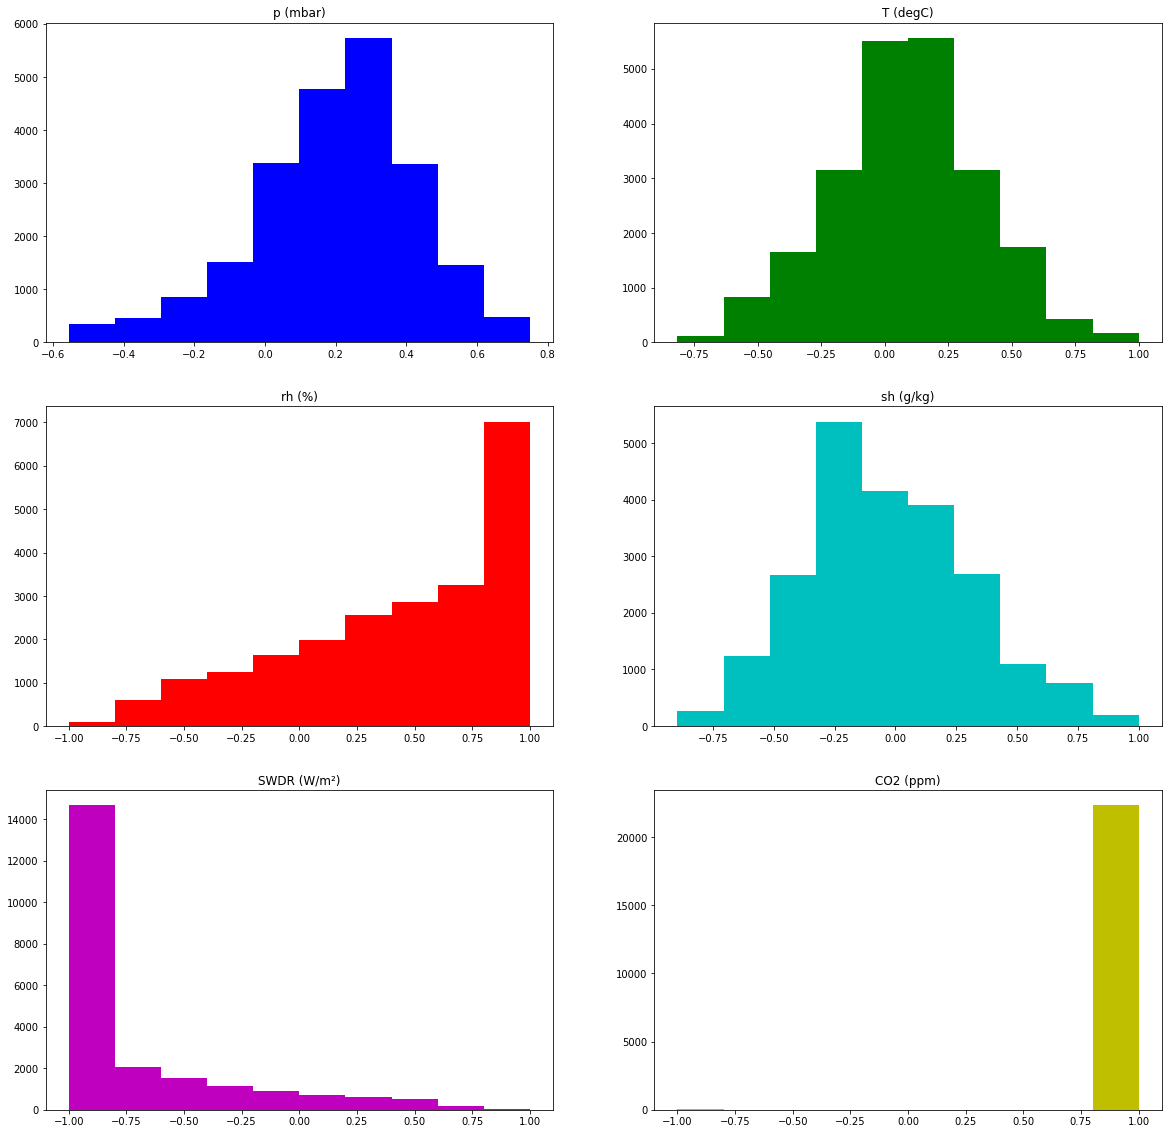

In [14]:
plot_histogram(3,2,train,col_names,colors)

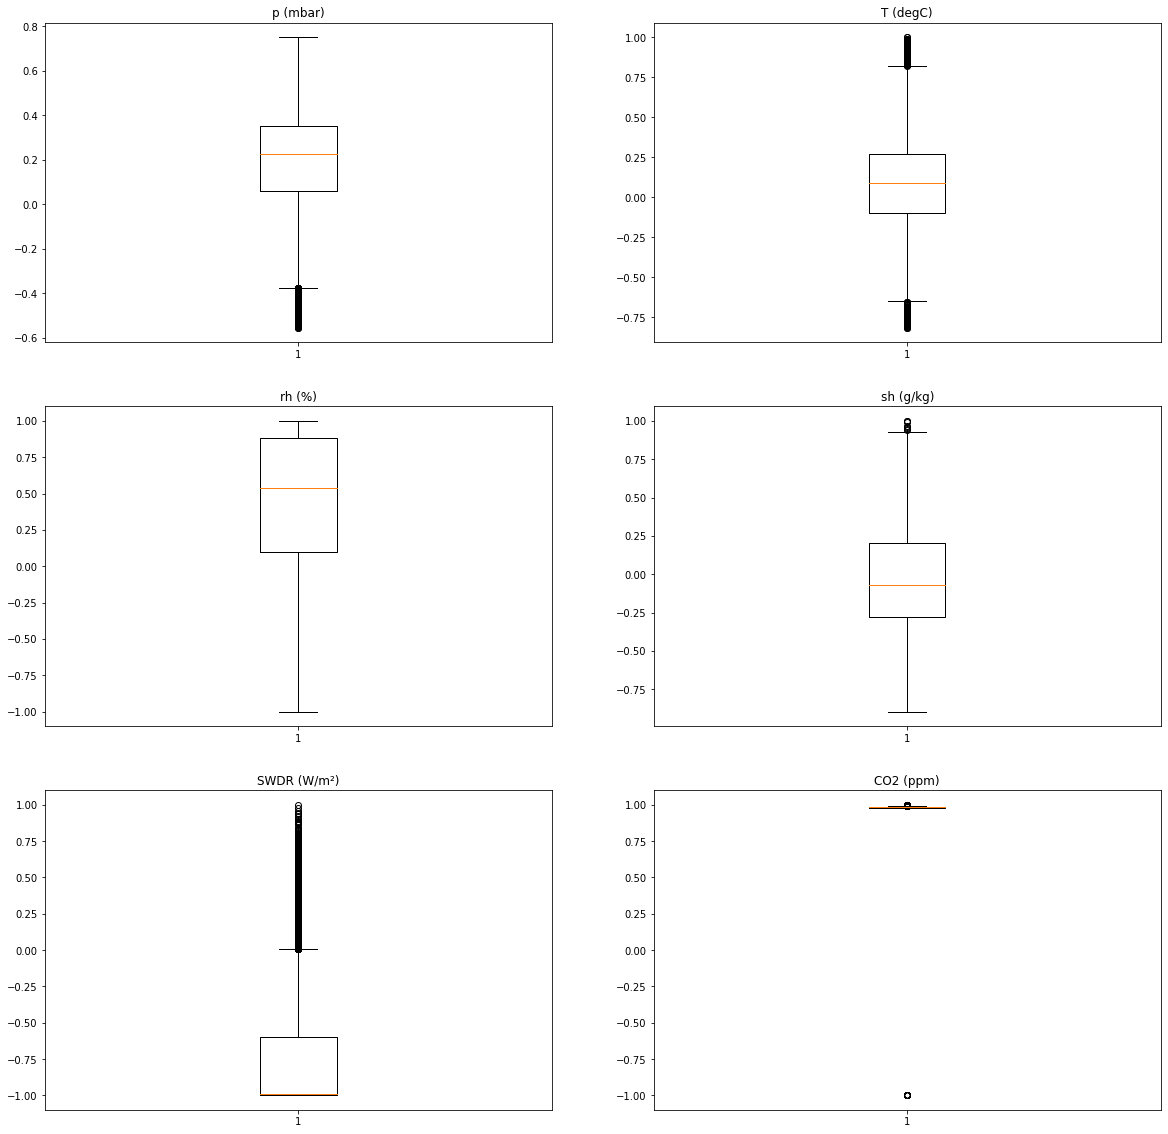

In [15]:
plot_boxplot(3,2,train,col_names,colors)

In [16]:
def remove_anomaly(train,index,anomaly_idx_list):
    for i in range(len(anomaly_idx_list)):
        size = 0
        mean = 0
        for j in range(anomaly_idx_list[i]-100,anomaly_idx_list[i]+101):
            if(train.shape[0]-101>=j>=0 and j not in anomaly_idx_list ):
                size += 1
                mean += train[j,index]
#         print(mean/size)
        train[anomaly_idx_list[i],index] = mean/size
    return train

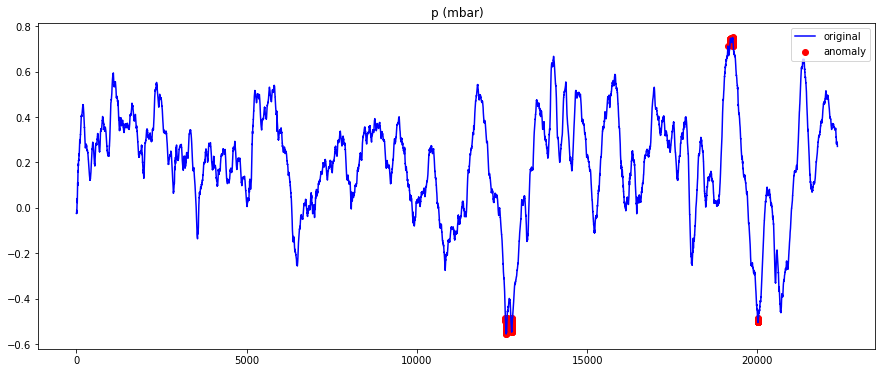

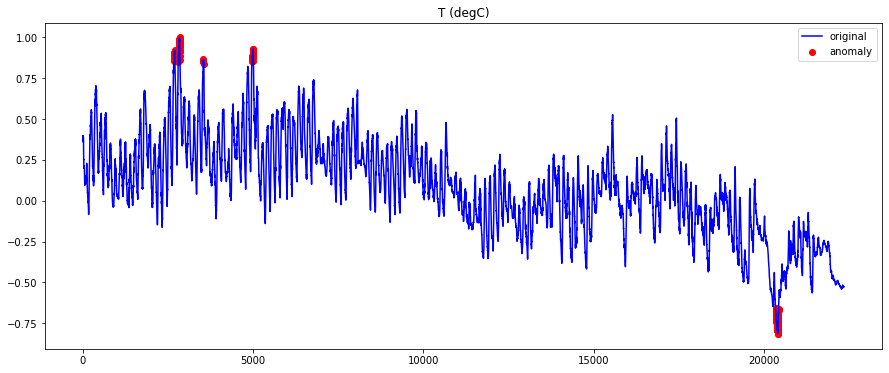

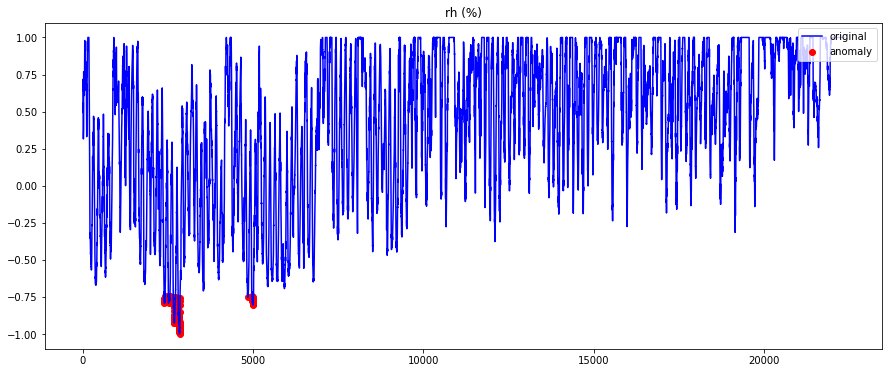

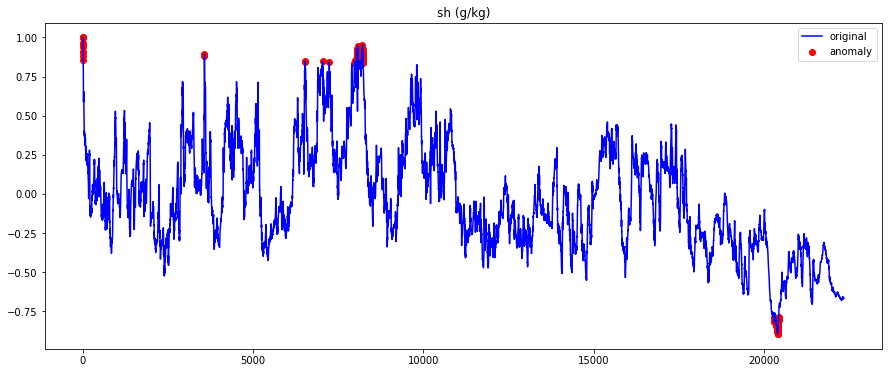

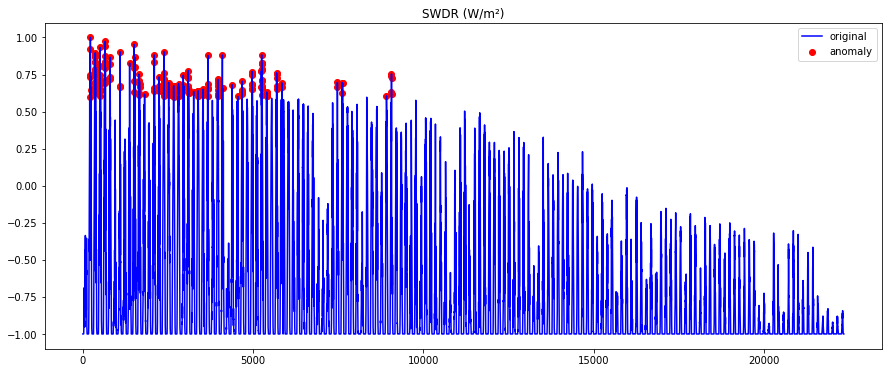

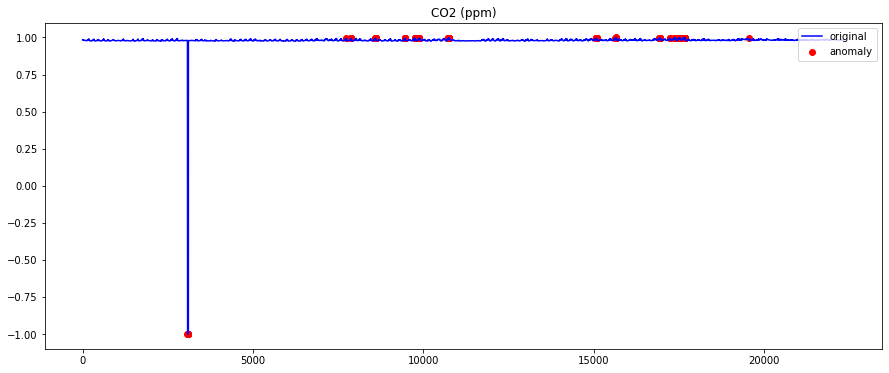

In [17]:
isolation_forest = IsolationForest(contamination=0.01)

for idx in range(train.shape[1]):
    dt_feature = [[item] for item in train[:,idx]]
    isolation_forest.fit(dt_feature)
    pred = isolation_forest.predict(dt_feature)
    anomaly = [i for i in range(len(pred)) if pred[i] == -1]
    
    train = remove_anomaly(train,idx,anomaly)
    
    anomaly_val = []
    for i in range(len(anomaly)):
        anomaly_val.append(dt_feature[anomaly[i]])
    plt.plot(dt_feature,color='b')
    plt.title(col_names[idx])
    plt.scatter(anomaly,anomaly_val,color='r')
    plt.legend(['original','anomaly'], loc='upper right')
    plt.show()



In [18]:
# def remove_anomaly(train,index,min_boundary=-1,max_boundary=1):
#     remove_row = []
#     mean = np.mean(train[:,index])
#     for i in range(train.shape[0]):
#         if (min_boundary>train[i,index] or max_boundary<train[i,index]):
#             train[i,index] = mean
# #             if train.shape[0]-1>i>0:
# #                 train[i,index] = (train[i,index]+train[i-1,index] + train[i+1,index])/3
                
#             remove_row = np.append(remove_row,i)
# #     if remove_row!=[]:
# #         remove_row = remove_row.astype(int)
#         # delete
#         # train = np.delete(train, remove_row,axis=0)
#         # correct
#     print(len(remove_row))
#     return train

In [19]:
# # remove anomalies
# train = remove_anomaly(train,5,min_boundary=0.95,max_boundary=0.9921) # CO2
# # print(train_wo_anomaly)
# train = remove_anomaly(train,4,max_boundary=0.778)
# # print(train)

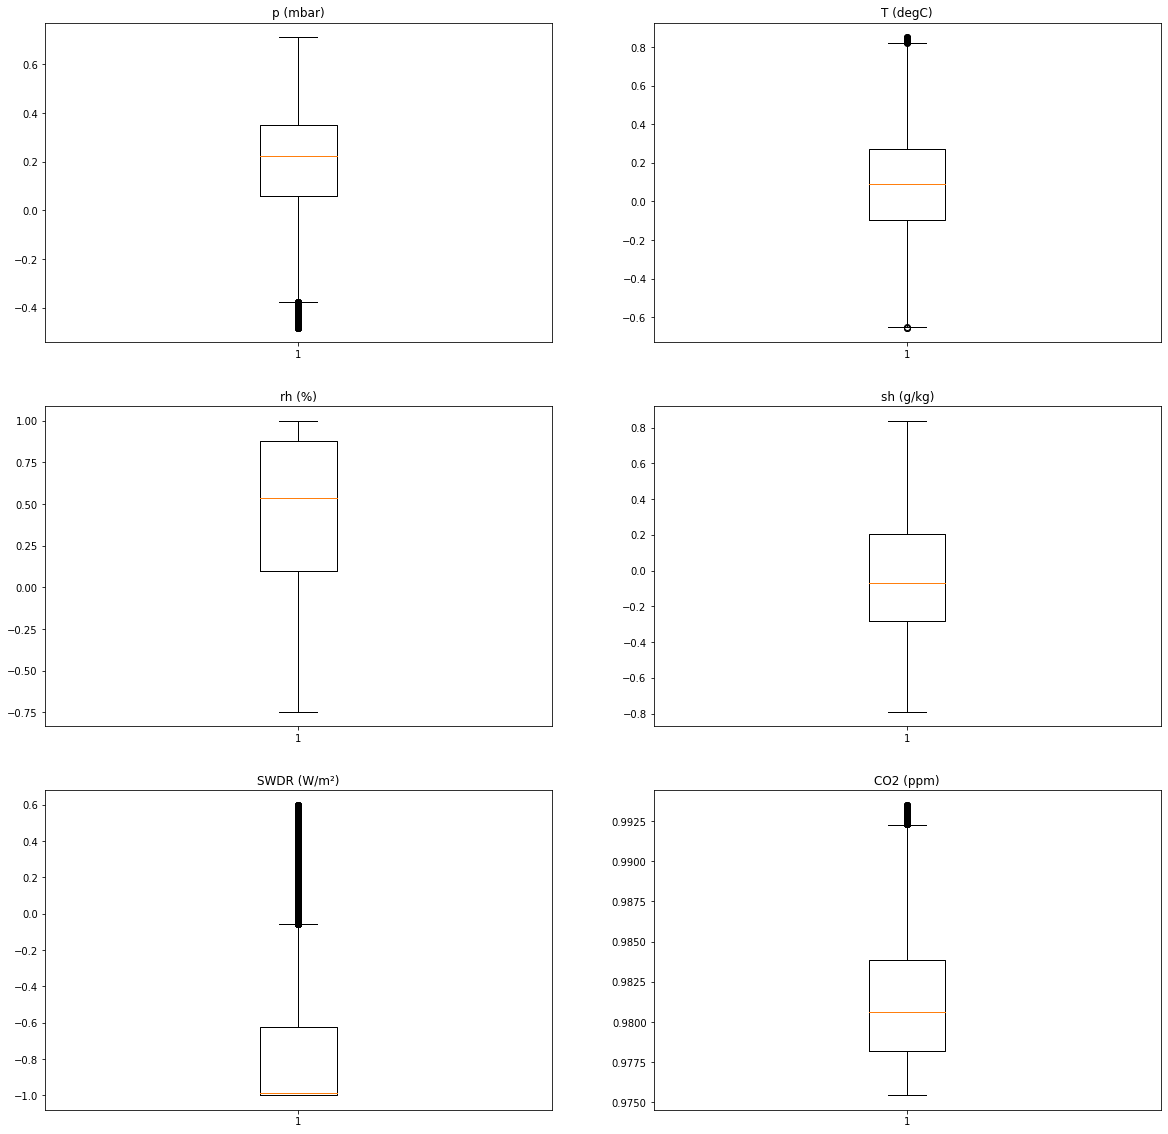

In [20]:
# print(train)
plot_boxplot(3,2,train,col_names,colors)

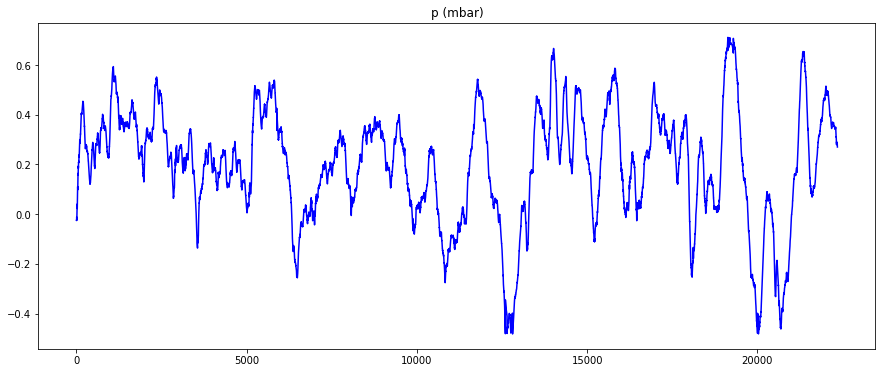

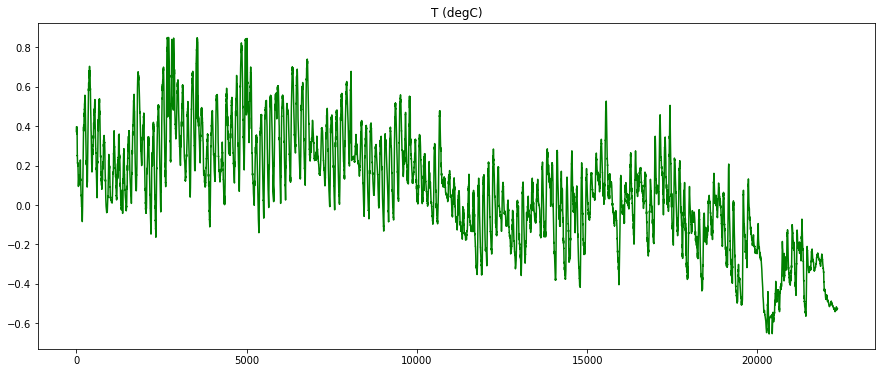

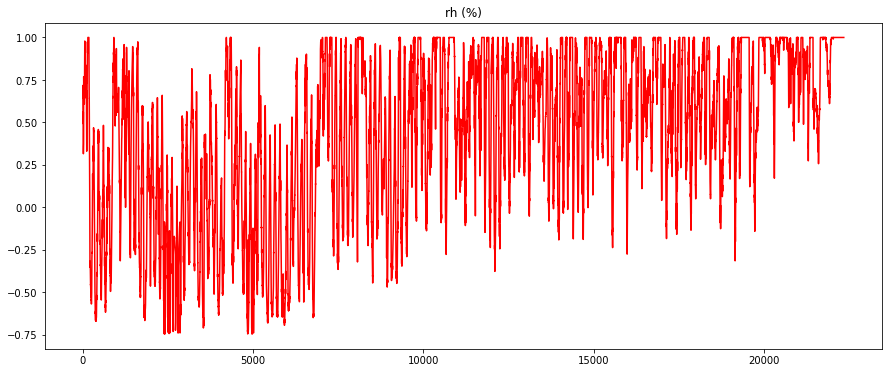

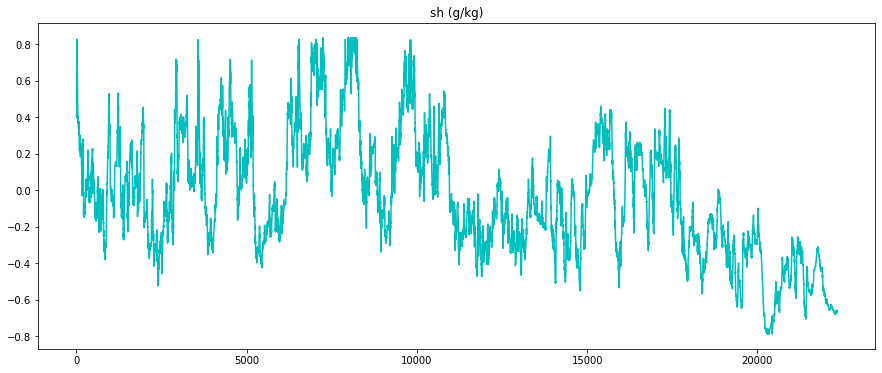

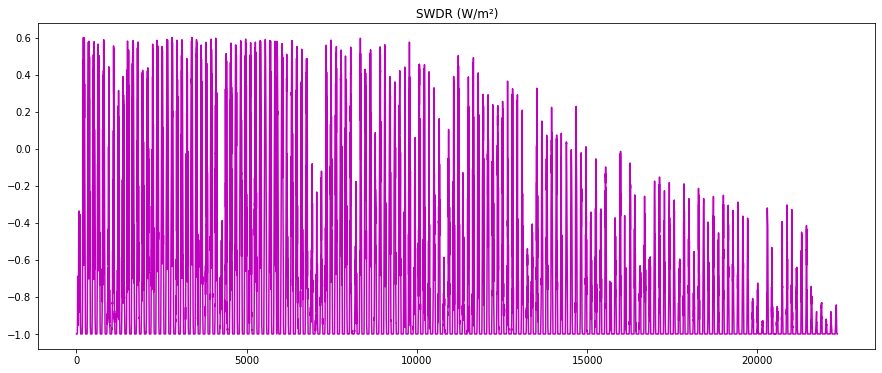

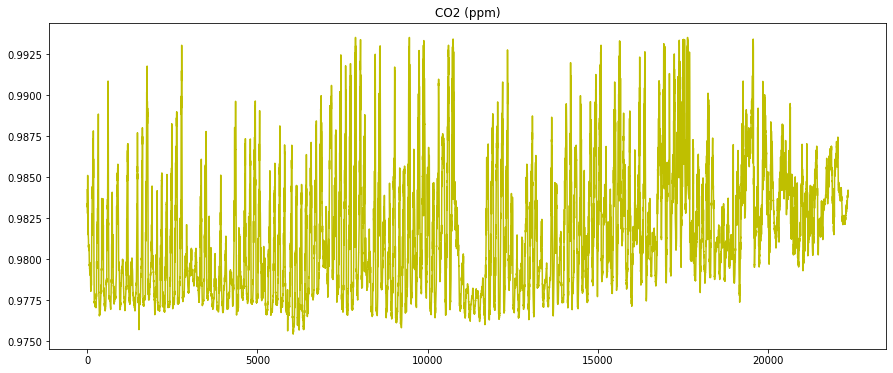

In [21]:
for i in range(train.shape[1]):
    plt.plot(train[:,i],color=colors[i])
    plt.title(col_names[i])
    plt.show()


In [22]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(0,len(sequences),n_steps_in):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [23]:
n_features = 6
n_months_in = 100
n_months_out = 100
X_train, y_train = split_sequences(train,n_months_in,n_months_out)
X_test, y_test = split_sequences(test,n_months_in,n_months_out)

In [24]:
# print(train[0:n_months_in+n_months_out,:])
# print("---------------------------------------------------------------")
# print(X_train[0:1,:])
# print("---------------------------------------------------------------")
# print(y_test[0:1,:])
# print("---------------------------------------------------------------")
print(train.shape)
print(test.shape)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(22351, 6)
(9579, 6)
(222, 100, 6) (222, 100, 6)
(94, 100, 6) (94, 100, 6)


In [25]:
y_train = y_train.reshape(y_train.shape[0],n_months_out*n_features)
y_test = y_test.reshape(y_test.shape[0],n_months_out*n_features)
print(y_train.shape)
print(y_test.shape)

(222, 600)
(94, 600)


In [26]:
batch_size = 1
model = Sequential()
model.add(LSTM(32,return_sequences=True,batch_input_shape=(batch_size,n_months_in,n_features),stateful=True))
model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_months_out*n_features))


In [27]:
# 
model.compile(optimizer=Adam(learning_rate=0.00001), loss="mse")
epochs = 1000
validation_split = 0.3 # 30% validation set
train_loss = []
val_loss = []
for i in range(epochs):
    history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=1,validation_split=validation_split,shuffle=False)
    train_loss.append(history.history["loss"])
    val_loss.append(history.history["val_loss"])
    model.reset_states()


155/155 [==============================] - 11s 71ms/step - loss: 0.1139 - val_loss: 0.1331


155/155 [==============================] - 9s 57ms/step - loss: 0.1033 - val_loss: 0.1204


155/155 [==============================] - 11s 73ms/step - loss: 0.0837 - val_loss: 0.0988


155/155 [==============================] - 11s 74ms/step - loss: 0.0710 - val_loss: 0.0822


155/155 [==============================] - 11s 74ms/step - loss: 0.0616 - val_loss: 0.0748


155/155 [==============================] - 10s 64ms/step - loss: 0.0556 - val_loss: 0.0690


155/155 [==============================] - 11s 74ms/step - loss: 0.0499 - val_loss: 0.0652


155/155 [==============================] - 12s 77ms/step - loss: 0.0451 - val_loss: 0.0598


155/155 [==============================] - 8s 54ms/step - loss: 0.0435 - val_loss: 0.0584


155/155 [==============================] - 9s 58ms/step - loss: 0.0410 - val_loss: 0.0552


155/155 [==============================] - 9s 61ms/step - loss: 0.0388 - val_loss: 0.0535


155/155 [==============================] - 10s 67ms/step - loss: 0.0399 - val_loss: 0.0530


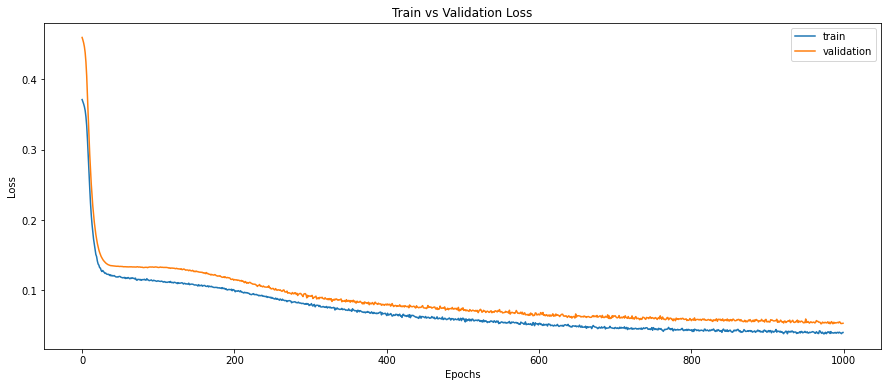

In [28]:
# plot the validation and training loss
plt.figure(figsize=(15,6))
plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Train vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [29]:
# SAVE AND LOAD MODEL
# model.save("model2.h5")

# load model
# model = load_model('model2.h5')

In [30]:
# prediction
y_pred = np.zeros((y_test.shape[0],y_test.shape[1]))
X_test_model = np.zeros((X_test[0].shape[0],X_test[0].shape[1]))
for i in range(X_test[0].shape[0]):
    for j in range(X_test[0].shape[1]):
        X_test_model[i][j] = X_test[0][i][j]

# print(X_test[0],X_test.shape)
# print(X_test_model,X_test_model.shape)

In [31]:
for i in range(X_test.shape[0]):
    
#     print("Before\n")
#     print(X_test_model)
    X_test_model = X_test_model.reshape(1,n_months_in,n_features)
#     print("Before\n")
#     print(X_test_model)
    pred = model.predict(X_test_model, verbose=0)
    X_test_model.reshape(n_months_in,n_features)
#     print("Predicted\n")
#     print(pred)
#     print("Actual")
#     print(y_test[i])
    y_pred[i]=pred
#     print("y_pred all")
#     print(y_pred[i])
#     print("y_test all")
#     print(y_test[i])
    pred=pred.reshape(n_months_out,n_features)
#     print(pred)

    X_test_model[0,:-n_months_out] = X_test_model[0,n_months_out:]
    X_test_model[0,-n_months_out:] = pred
#     print("After")
#     print(X_test_model)
    


In [32]:
# y_pred = y_pred.reshape(y_test.shape[0],n_months_out*n_features)
# print(y_pred.shape)
y_pred_inv = np.zeros_like(y_pred)
y_test_inv = np.zeros_like(y_test)
for i in range(1,n_months_out+1):
#     print(i)
    y_pred_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_pred[:,(i-1)*n_features:i*n_features])
#     print(scaler.inverse_transform(y_pred[0:3,(i-1)*n_features:i*n_features]))
#     print("--------------------------------------------------------- i= ",i)
#     print(y_pred_inv[0:3,:])
#     print("--------------------------------------------------------- test")
    
    
    y_test_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_test[:,(i-1)*n_features:i*n_features])
#     print(y_test_inv[0:10,:])
rmse = mean_squared_error(y_test_inv, y_pred_inv) ** (0.5)
print('Test RMSE: %.3f ' % rmse )

Test RMSE: 99.485 


In [33]:
y_test_re = y_test_inv.reshape(n_months_out*y_test_inv.shape[0], n_features)
y_pred_re = y_pred_inv.reshape(n_months_out*y_pred_inv.shape[0], n_features)
print(y_pred_re.shape)
print(y_test_re.shape)
rmse = mean_squared_error(y_test_re, y_pred_re) ** (0.5)
print('Test RMSE: %.3f ' % rmse )

(9400, 6)
(9400, 6)
Test RMSE: 99.485 


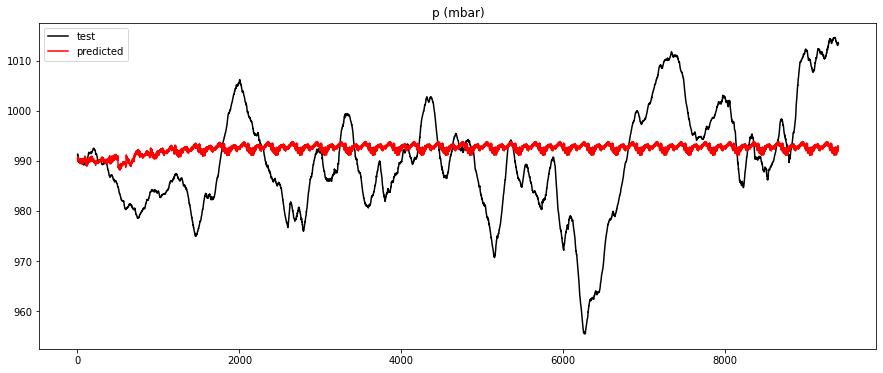

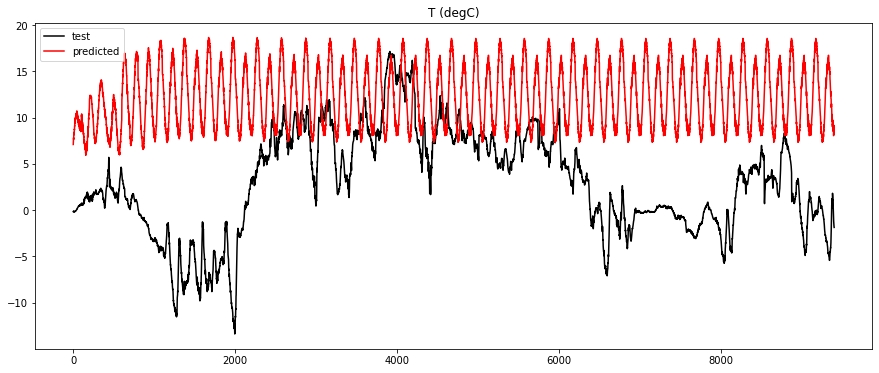

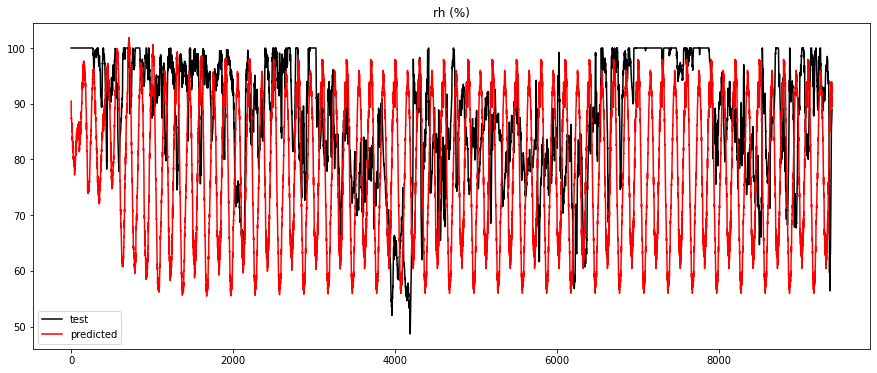

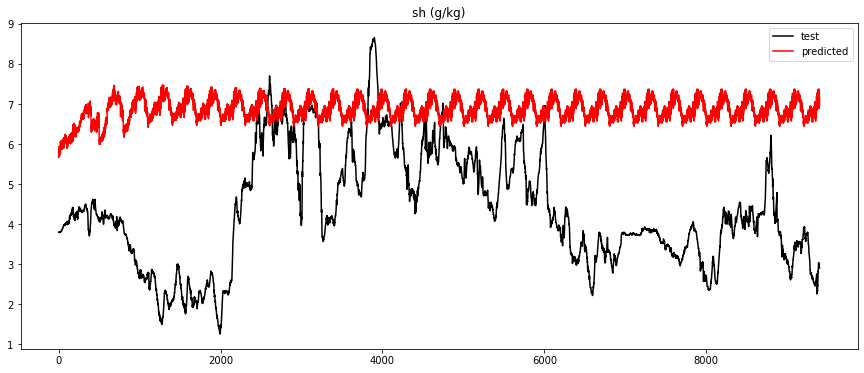

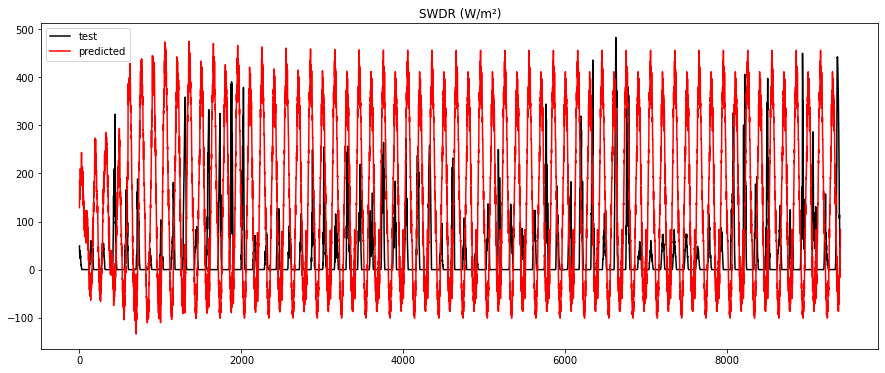

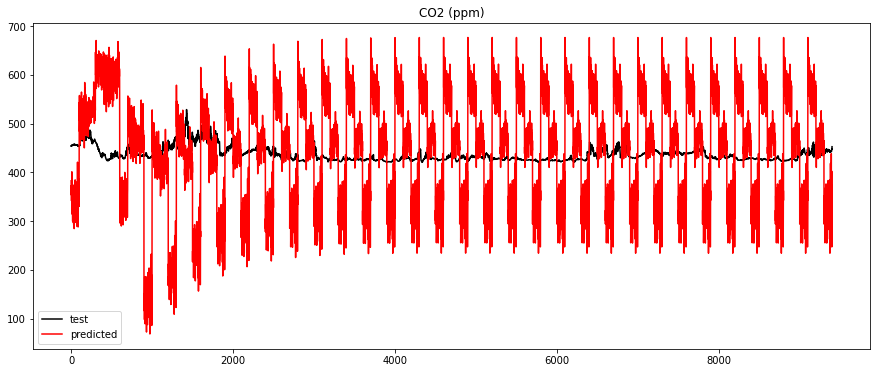

In [34]:
for i in range(n_features):
    plt.plot(y_test_re[:,i],color='black')
    plt.plot(y_pred_re[:,i],color='red')
    plt.legend(["test","predicted"])
    plt.title(col_names[i])
    plt.show()


In [35]:
# # predict train
# y_pred_tr = np.zeros((y_train.shape[0],y_train.shape[1]))
# X_train_model = np.zeros((X_train[0].shape[0],X_train[0].shape[1]))
# for i in range(X_train[0].shape[0]):
#     for j in range(X_train[0].shape[1]):
#         X_train_model[i][j] = X_train[0][i][j]

# for i in range(X_train.shape[0]):
#     X_train_model = X_train_model.reshape(1,n_months_in,n_features)
#     pred = model.predict(X_train_model, verbose=0)
#     X_train_model.reshape(n_months_in,n_features)
#     y_pred_tr[i]=pred
#     pred=pred.reshape(n_months_out,n_features)
#     X_train_model[0,:-n_months_out] = X_train_model[0,n_months_out:]
#     X_train_model[0,-n_months_out:] = pred

# y_pred_tr_inv = np.zeros_like(y_pred_tr)
# y_train_inv = np.zeros_like(y_train)
# for i in range(1,n_months_out+1):
#     y_pred_tr_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_pred_tr[:,(i-1)*n_features:i*n_features])
#     y_train_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_train[:,(i-1)*n_features:i*n_features])
# rmse = mean_squared_error(y_train_inv, y_pred_tr_inv) ** (0.5)
# print('Test RMSE: %.3f ' % rmse )


# for i in range(n_features):
#     plt.plot(y_train_inv[:,i],color='black')
#     plt.plot(y_pred_tr_inv[:,i],color='red')
#     plt.legend(["train","predicted"])
#     plt.title(col_names[i])
#     plt.show()

In [36]:
# for i in range(n_features):
#     plt.plot(y_train_inv[:5000,i],color='black')
#     plt.plot(y_pred_tr_inv[:5000,i],color='red')
#     plt.legend(["train","predicted"])
#     plt.title(col_names[i])
#     plt.show()